In [ ]:
                             import os
if input("Are you using Google Colab? y/n") in ['y','Y']:
  from google.colab import auth
  auth.authenticate_user()
  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')
  from google.colab import drive
  drive.mount('/content/drive')
  input_dir='/content/drive/My Drive/NNDL/FP/data/'
else:
  input_dir='C:/[where your directory is on your laptop]/images'
  target_dir='C:/[where your directory is on your laptop]/annotations/trimaps'

Are you using Google Colab? y/ny
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#set up the environment
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import os
import time

Tensorflow version: 2.8.0


In [ ]:
import gdown
from zipfile import ZipFile

os.makedirs("celeba_gan",exist_ok=True)
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


In [ ]:
#show some sample pictures
input_img_paths = sorted([os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")])

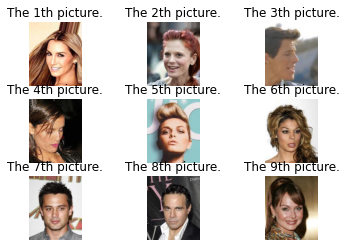

In [ ]:
import cv2 as cv
fig=plt.figure()
rows = 3
columns = 3
for i in range(9):
    image = cv.imread(input_img_paths[i])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    pixels = np.array(image)
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(pixels)
    plt.axis('off')
    plt.title("The "+str(i+1)+"th picture.")


#Shape and type are perfect.

In [ ]:
image3DMatrix = tf.keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)

Found 202599 files belonging to 1 classes.


In [ ]:
image3DMatrix = image3DMatrix.map(lambda x: x-127.5 / 127.5)


# **Entering the** *Model* **part**

1.   Constructing discriminator
2.   Constructing generator



#### Intermediate layers for discriminator and generator

So why do these why the model allow us to determine is the faces are real human faces or not?

At a high level, in order for a network to perform image classification (which the discriminator part has been trained to do), it must understand the image. Human biological viusal system can do this every fast because we have been trained to do so when we are young and the "weight" or "feature" are stored in the brains. But for a blank model, this requires taking the raw image as input 
pixels and building a fram of layers that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By defining layers of the model, you're able to describe the content and style of input images.
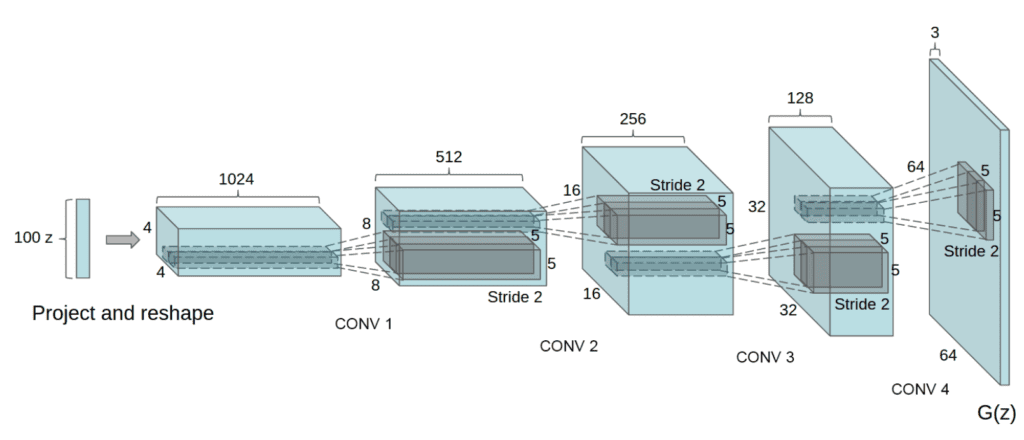

# The ways to stable the GANs
Perhaps one of the most important steps forward in the design and training of stable GAN models was the 2015 paper by Alec Radford, et al. In the paper he introduced a few recommendations for the GAN architecture.

[--Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).
we also implement most of them in the model.
> 1. Use Strided Convolutions
> 2. Remove Fully-Connected Layers
> 3. Use Batch Normalization
> 4. Use ReLU, Leaky ReLU, and Tanh
> 5. Use Adam Optimization




In [ ]:
from functools import partial
from tensorflow import keras
from keras import models
from keras import layers
from keras.layers import BatchNormalization,Input, Dense, Reshape, Conv2D,LeakyReLU, Conv2DTranspose, Flatten, Dropout, GaussianNoise,Concatenate
from keras.models import Model

#1.Discriminator

def getDiscriminator():
  # inputLayerDis = Input(shape=(64,64,3),name = "inputLayerDis")
  inputLayerDis = Input(shape=(64,64,3),name = "inputLayerDis")
  # tmp = Conv2DLayer(filters=32,strides=1,name="con2DLayerDis1")(inputLayerDis)
  tmp = Conv2D(64, kernel_size=4, strides=2, padding="same",name="con2DLayerDis1")(inputLayerDis)
  tmp = BatchNormalization()(tmp)
  tmp = LeakyReLU(alpha=0.2)(tmp)
 
  # tmp = Conv2DLayer(filters=64,strides=2,name="con2DLayerDis2")(tmp)
  tmp = Conv2D(128, kernel_size=4, strides=2, padding="same",name="con2DLayerDis2")(inputLayerDis)
  tmp = BatchNormalization()(tmp)
  tmp = LeakyReLU(alpha=0.2)(tmp)
  # tmp = Conv2DLayer(filters=64,strides=2,name="con2DLayerDis3")(tmp)
  # tmp=LeakyReLU(alpha=0.2)(tmp)
  # tmp = Conv2DLayer(filters=64,strides=2,name="con2DLayerDis4")(tmp)
  tmp = Flatten()(tmp)

  outputDenseLayerDis = Dense(1,activation="sigmoid",name="outputDenseLayerDis")(tmp)
  return Model(inputLayerDis,outputDenseLayerDis,name="Discriminator")

discriminator = getDiscriminator()
discriminator.summary()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayerDis (InputLayer)  [(None, 64, 64, 3)]       0         
                                                                 
 con2DLayerDis2 (Conv2D)     (None, 32, 32, 128)       6272      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 outputDenseLayerDis (Dense)  (None, 1)                131073    
                                                     

In [ ]:
# 2.Generator
latent_dim = 128


def getGenerator():
  inputLayerGen = Input(shape=(latent_dim,),name = "inputLayerGen")
  # tmp = Dense(128*16*16)(inputLayerGen)
  tmp = Dense(8*8*128)(inputLayerGen)
  # tmp=LeakyReLU(alpha=0.3)(tmp)
  # tmp = Reshape((16,16,128))(tmp)
  tmp = Reshape((8,8,128))(tmp)

  # tmp = Conv2DLayer(filters=256,kernel_size=2,strides=2,name="con2DLayer1")(tmp)
  # tmp=LeakyReLU(alpha=0.3)(tmp)


  # tmp = Conv2DTransLayer(128,kernel_size=4,strides=2,padding='same',name="con2DTLayer1")(tmp)
  tmp = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",name="con2DTLayer1")(tmp)
  tmp = BatchNormalization()(tmp)
  tmp = LeakyReLU(0.2)(tmp)
  # tmp = Conv2DTransLayer(128,kernel_size=4,strides=2,padding='same',name="con2DTLayer2")(tmp)
  tmp = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same",name="con2DTLayer2")(tmp)
  tmp = BatchNormalization()(tmp)
  tmp = LeakyReLU(0.2)(tmp)
  # tmp = Conv2DTransLayer(128,kernel_size=4,strides=4,padding='same',name="con2DTLayer3")(tmp)
  tmp = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",name="con2DTLayer3")(tmp)
  tmp = BatchNormalization()(tmp)
  tmp = LeakyReLU(0.2)(tmp)


  # tmp = Conv2D(512,kernel_size=5,padding='same',name="con2DLayer2")(tmp)
  # tmp = LeakyReLU()(tmp)
  # tmp = Conv2D(512,kernel_size=5,padding='same',name="con2DLayer3")(tmp)
  # tmp = LeakyReLU()(tmp)
  # outputLayerGen = Conv2DLayer(3,activation='tanh', padding='same',name='outputLayerGen')(tmp)
  outputLayerGen = Conv2D(3, kernel_size=5, padding="same", activation="tanh")(tmp)
  return Model(inputLayerGen,outputLayerGen,name="Generator")

generator = getGenerator()
generator.summary()



Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayerGen (InputLayer)  [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 con2DTLayer1 (Conv2DTranspo  (None, 16, 16, 128)      262272    
 se)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal([batch_size, self.latent_dim],0,1)

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal([batch_size, self.latent_dim],0,1)

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim),0,1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images*127.5+127.5
        generated_images.numpy()
        if epoch % 1 == 0:
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f"{target_dir}/generated1_%03d_%d.png" % (epoch, i))

# Compile
In the GANS we use `keras.optimizers.Adam` for both of the models.In addition to storing an exponentially decaying average of past squared gradients v like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients m, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface. In fact, `Adam ` achieves good results fast.

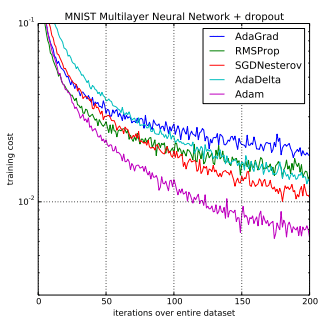

For the choose of the loss function, we choose `keras.losses.BinaryCrossentropy`
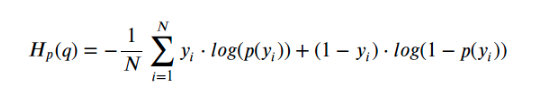

This is the loss function where y is the label (1 for real human face and 0 for fake(computer generated)) and p(y) is the predicted probability of the point being real for all N points.
Adam in detail: The suggested learning rate for the Adam is 0.001, first I change it in to 0.0001 to avoid, at least trying to jumping back and forth over the optimal point. As the training and optimization going on, the situation still happened.

In [ ]:
epochs = 30  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history1 = gan.fit(
    image3DMatrix, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/30
6332/6332 [==============================] - 296s 47ms/step - d_loss: 0.7265 - g_loss: 0.9871
Epoch 2/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7364 - g_loss: 0.9707
Epoch 3/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7443 - g_loss: 0.9554
Epoch 4/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7460 - g_loss: 0.9355
Epoch 5/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7799 - g_loss: 0.9175
Epoch 6/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7763 - g_loss: 0.8435
Epoch 7/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7727 - g_loss: 0.8494
Epoch 8/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7707 - g_loss: 0.8252
Epoch 9/30
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7683 - g_loss: 0.8052
Epoch 10/30
6332/6332 [==============================] 

In [ ]:
gV1P='/content/drive/My Drive/NNDL/FP/model/tanh/v1/gen'
dV1p='/content/drive/My Drive/NNDL/FP/model/tanh/v1/dis'
rV1p='/content/drive/My Drive/NNDL/FP/model/tanh/v1/rec'

os.makedirs(gV1P,exist_ok=True)
os.makedirs(dV1p,exist_ok=True)
os.makedirs(rV1p,exist_ok=True)
# generator.save(gV1P)
# discriminator.save(dV1p)
# np.save(f'{rV1p}/history1.npy',history1.history)
history_remake=np.load(f'{rV1p}/history1.npy',allow_pickle='TRUE').item()


In [ ]:
history_remake

{'d_loss': [0.7184911966323853, 0.7635118365287781],
 'g_loss': [1.269834041595459, 0.9932469725608826]}

In [ ]:
from keras.saving.save import load_model
epochs = 20  # In practice, use ~100 epochs

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim),0,1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images*127.5+127.5
        generated_images.numpy()
        if epoch % 2 == 0:
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f"{target_dir}/generated2_%03d_%d.png" % (epoch, i))

gan = GAN(discriminator=load_model(dV1p), generator=load_model(gV1P), latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005,beta_1=0.7),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005,beta_1=0.7),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history2 = gan.fit(
    image3DMatrix, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/20
6332/6332 [==============================] - 301s 47ms/step - d_loss: 0.7708 - g_loss: 0.7141
Epoch 2/20
6332/6332 [==============================] - 296s 47ms/step - d_loss: 0.7368 - g_loss: 0.7554
Epoch 3/20
6332/6332 [==============================] - 294s 46ms/step - d_loss: 0.7285 - g_loss: 0.7620
Epoch 4/20
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7216 - g_loss: 0.7724
Epoch 5/20
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7213 - g_loss: 0.7623
Epoch 6/20
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7150 - g_loss: 0.7773
Epoch 7/20
6332/6332 [==============================] - 295s 47ms/step - d_loss: 0.7075 - g_loss: 0.7835
Epoch 8/20
6332/6332 [==============================] - 294s 46ms/step - d_loss: 0.7179 - g_loss: 0.7709
Epoch 9/20
6332/6332 [==============================] - 292s 46ms/step - d_loss: 0.7092 - g_loss: 0.7750
Epoch 10/20
6332/6332 [==============================] 

In [ ]:
gV2P='/content/drive/My Drive/NNDL/FP/model/tanh/v2/gen'
dV2p='/content/drive/My Drive/NNDL/FP/model/tanh/v2/dis'
rV2p='/content/drive/My Drive/NNDL/FP/model/tanh/v2/rec'

os.makedirs(gV2P,exist_ok=True)
os.makedirs(dV2p,exist_ok=True)
os.makedirs(rV2p,exist_ok=True)
generator.save(gV2P)
discriminator.save(dV2p)
np.save(f'{rV2p}/history2.npy',history2.history)
history2_remake=np.load(f'{rV2p}/history2.npy',allow_pickle='TRUE').item()

In [ ]:
from keras.saving.save import load_model
epochs = 20  # In practice, use ~100 epochs

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim),0,1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images*127.5+127.5
        generated_images.numpy()
        if epoch % 2 == 0:
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f"{target_dir}/generated3_%03d_%d.png" % (epoch, i))

gan = GAN(discriminator=load_model(dV2p), generator=load_model(gV2P), latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history3 = gan.fit(
    image3DMatrix, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/20
6332/6332 [==============================] - 565s 87ms/step - d_loss: 0.7933 - g_loss: 0.6763
Epoch 2/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7795 - g_loss: 0.6769
Epoch 3/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7584 - g_loss: 0.6938
Epoch 4/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7341 - g_loss: 0.7161
Epoch 5/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7222 - g_loss: 0.7278
Epoch 6/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7145 - g_loss: 0.7348
Epoch 7/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7097 - g_loss: 0.7396
Epoch 8/20
6332/6332 [==============================] - 541s 85ms/step - d_loss: 0.7085 - g_loss: 0.7421
Epoch 9/20
6332/6332 [==============================] - 542s 86ms/step - d_loss: 0.7064 - g_loss: 0.7430
Epoch 10/20
6332/6332 [==============================] 

In [ ]:
gV3P='/content/drive/My Drive/NNDL/FP/model/tanh/v3/gen'
dV3p='/content/drive/My Drive/NNDL/FP/model/tanh/v3/dis'
rV3p='/content/drive/My Drive/NNDL/FP/model/tanh/v3/rec'

os.makedirs(gV3P,exist_ok=True)
os.makedirs(dV3p,exist_ok=True)
os.makedirs(rV3p,exist_ok=True)
generator.save(gV3P)
discriminator.save(dV3p)
np.save(f'{rV3p}/history3.npy',history3.history)
history3_remake=np.load(f'{rV3p}/history3.npy',allow_pickle='TRUE').item()

In [ ]:
from keras.saving.save import load_model
epochs = 20  # In practice, use ~100 epochs

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            p = '/content/drive/My Drive/NNDL/FP/data/outputCheckKeras'
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{p}/generatedv2r4_img_%04d_%d.png" % (epoch, i))

gan = GAN(discriminator=load_model(dV3p), generator=load_model(gV3P), latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    image3DMatrix, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

In [ ]:
gV4p='/content/drive/My Drive/NNDL/FP/model/v4/gen'
dV4p='/content/drive/My Drive/NNDL/FP/model/v4/dis'
os.makedirs(gV4p,exist_ok=True)
os.makedirs(dV4p,exist_ok=True)
generator.save(gV4p)
discriminator.save(dV4p)

INFO:tensorflow:Assets written to: /content/drive/My Drive/NNDL/FP/model/v4/gen/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/NNDL/FP/model/v4/gen/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/NNDL/FP/model/v4/dis/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/NNDL/FP/model/v4/dis/assets


# Result
We only trained the model over all 3 round with 60 epoch and it give us pretty resonable result. 
Here is some of the output of each round.

In [ ]:
outputList =[]

for round in range(3):
  for ep in range(20):
    i = np.random.randint(0, 10)
    outputList.append(f'/content/drive/My Drive/NNDL/FP/data/outputCheckKeras/generatedv2r%d_img_%03d_%d.png'% (round+2,ep, i))
outputList.sort()

    

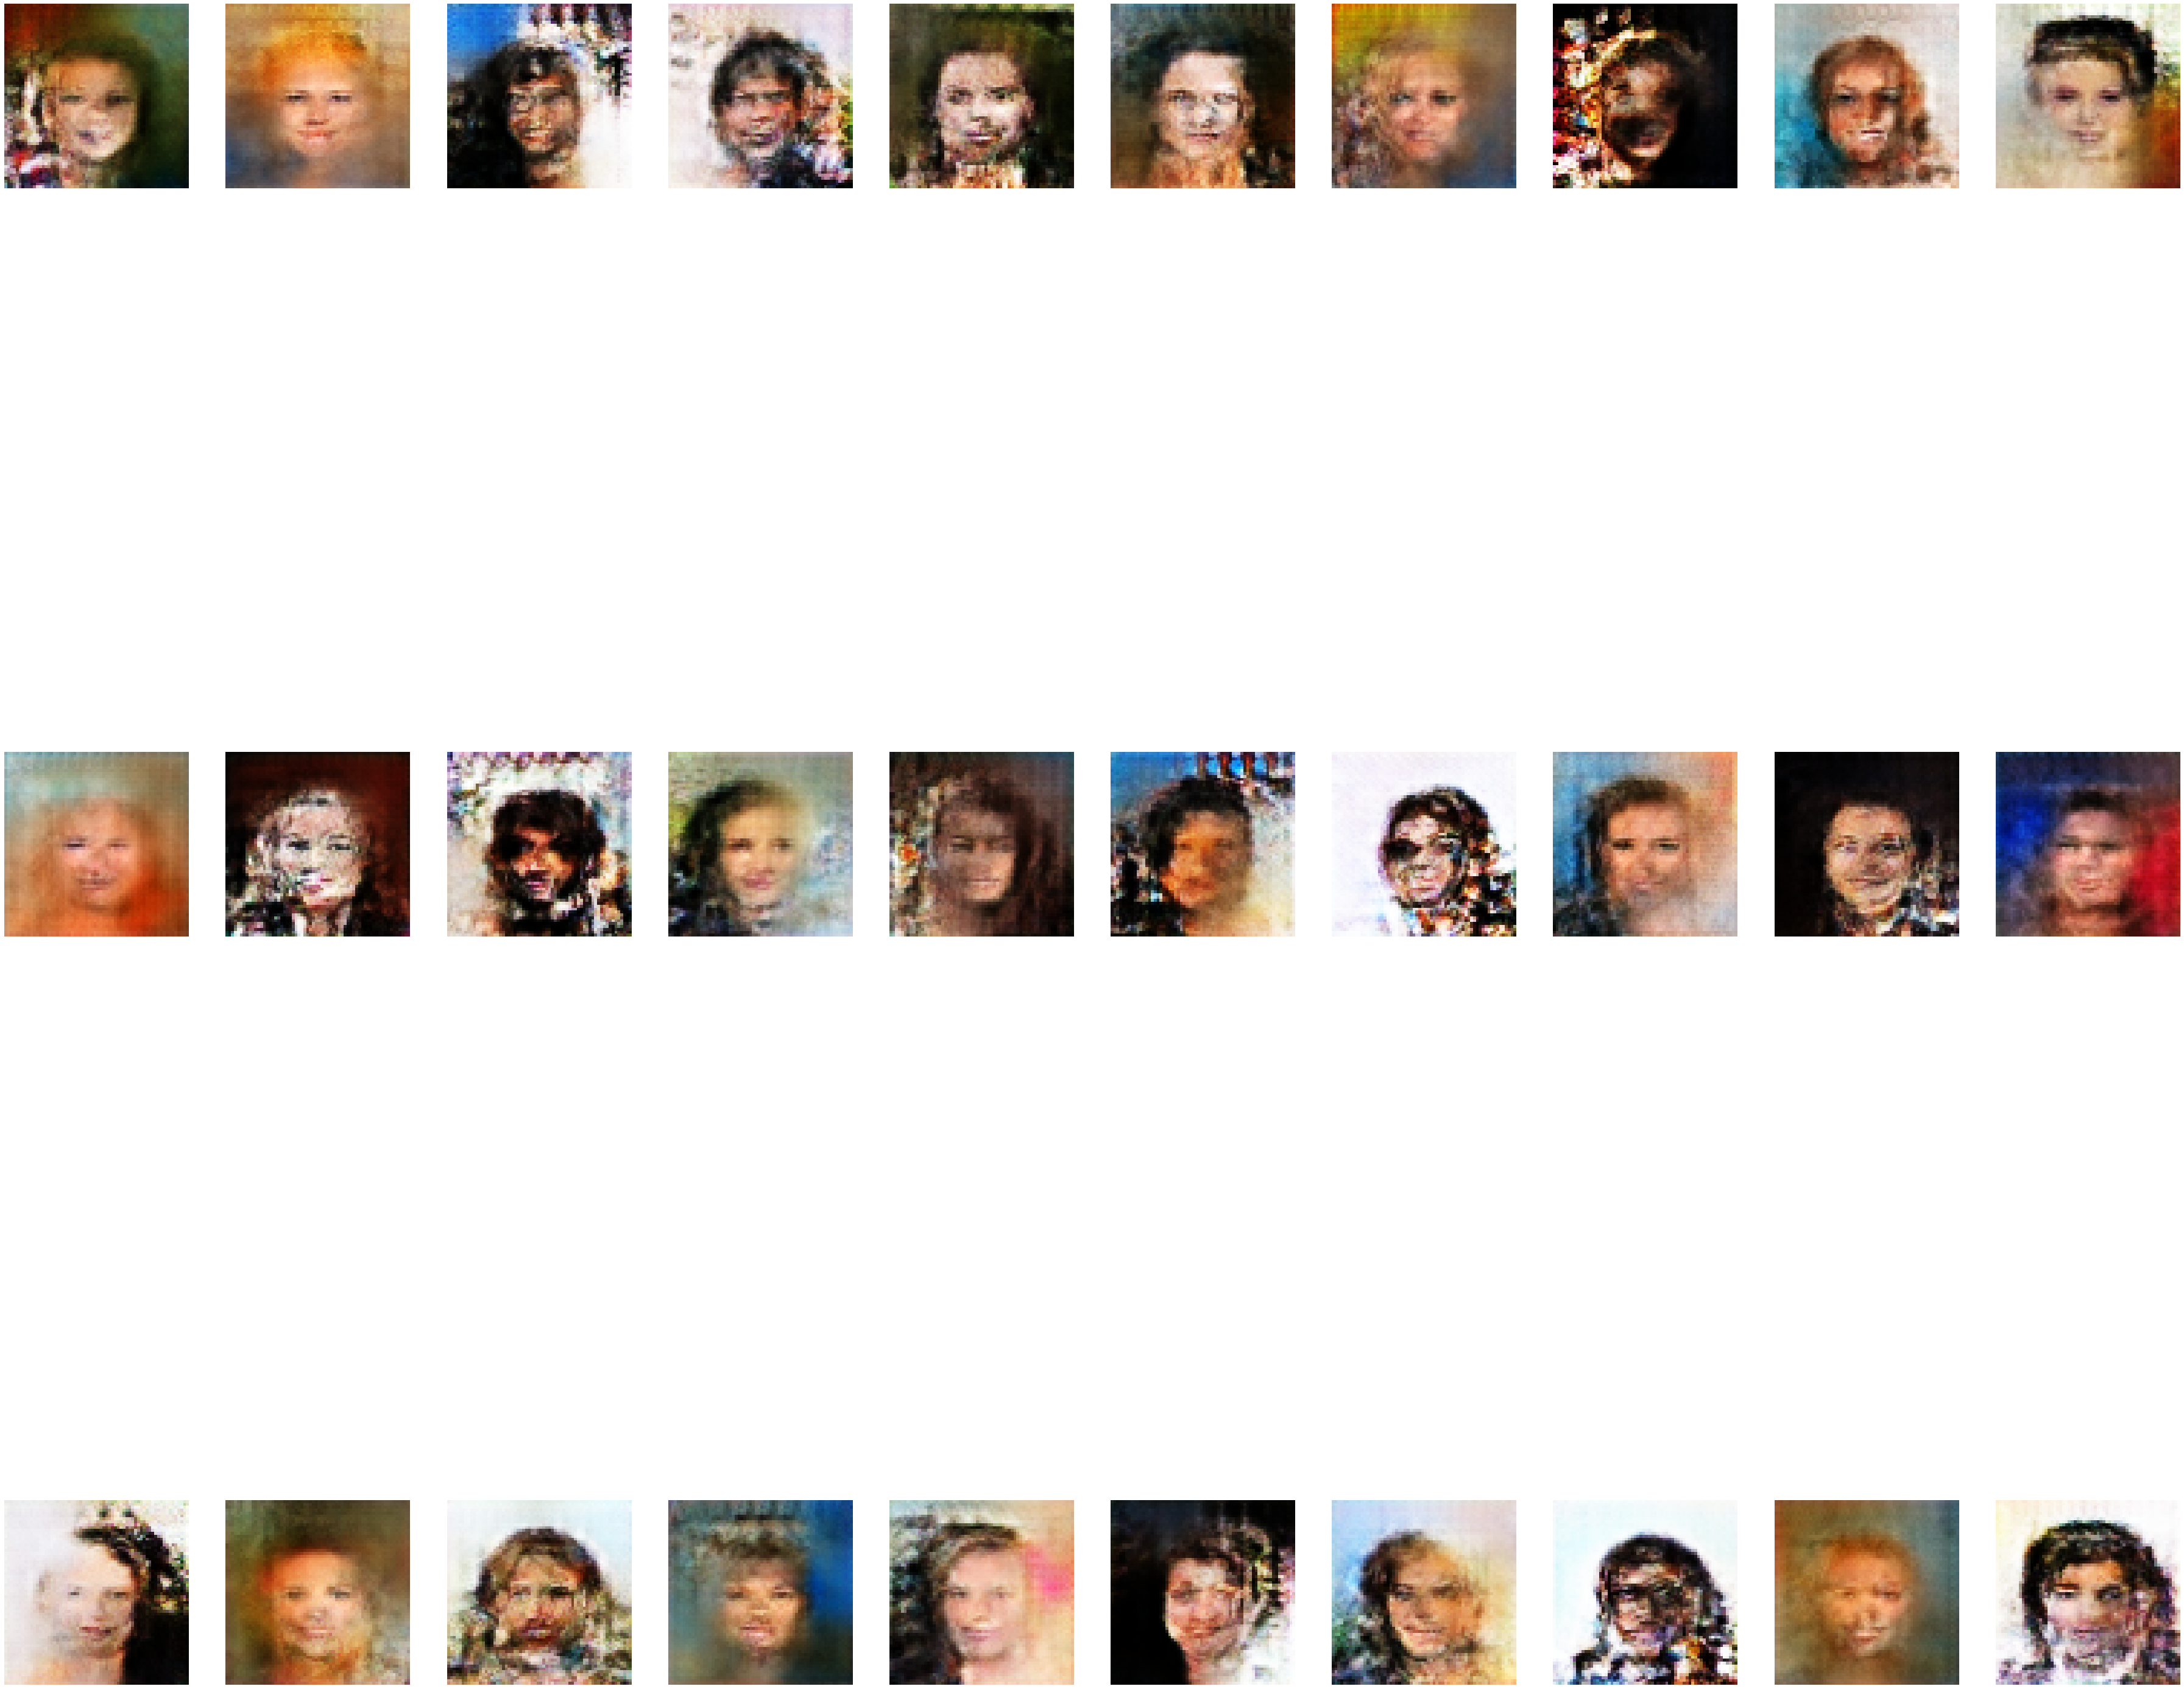

In [ ]:
import cv2 as cv
fig=plt.figure(figsize=(64,64))
rows = 3
columns = 10
z = 0


for i in range(30):
    image = cv.imread(outputList[i])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')